<a href="https://colab.research.google.com/github/MrckHckr/satellite-health-monitoring/blob/main/notebooks/03_lstm_failure_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM-based Failure Prediction

This notebook uses LSTM neural networks to predict future subsystem failures
based on multivariate satellite telemetry time series.

Output:
- Probability of failure
- Decision support for satellite operations

OBIETTIVO

Prevedere guasti futuri dei sottosistemi

Stimare probabilità di failure

Supportare decisioni operative (intervenire / non intervenire)

In [2]:
# Import librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [3]:
# Caricamento dati da GitHub
url = "https://raw.githubusercontent.com/MrckHckr/satellite-health-monitoring/main/data/raw/telemetry.csv"

df = pd.read_csv(url, parse_dates=["timestamp"])

battery_df = df[df["subsystem"] == "battery"].copy()
battery_df.reset_index(drop=True, inplace=True)

battery_df.head()


,timestamp,temperature,battery_voltage,vibration,power,subsystem,failed
0,2025-01-01 00:00:00,22.3,28.1,0.02,120,battery,0
1,2025-01-01 01:00:00,22.8,28.0,0.02,119,battery,0
2,2025-01-01 02:00:00,23.5,27.8,0.03,118,battery,0
3,2025-01-01 03:00:00,25.2,27.2,0.05,115,battery,1


In [4]:
# Selezione feature e target
features = battery_df[[
    "temperature",
    "vibration",
    "power"
]]

target = battery_df["failed"]


In [5]:
# Normalizzazione
scaler = MinMaxScaler()

features_scaled = scaler.fit_transform(features)


In [6]:
# Creazione sequenze temporali
def create_sequences(X, y, window_size=5):
    X_seq, y_seq = [], []

    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y.iloc[i+window_size])

    return np.array(X_seq), np.array(y_seq)

WINDOW_SIZE = 3

X, y = create_sequences(features_scaled, target, WINDOW_SIZE)
print(X.shape, y.shape)



(1, 3, 3) (1,)


In [7]:
# Train / Test split
# Robust time-based split
split_index = int(len(X) * 0.8)
split_index = max(split_index, 1)

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]





In [8]:
# Modello LSTM
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Addestramento
if len(X_train) < 5:
    history = model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=1,
        verbose=1
    )
else:
    history = model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=16,
        validation_split=0.2,
        verbose=1
    )




Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.6211
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.6140
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.6207
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.6231
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.5812
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.5928
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.5688
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.5734
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.5450
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.5298
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.5071
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.5200
Epo

In [10]:
# Valutazione modello
# Valutazione modello (robusta per dataset piccoli)

if len(X_test) == 0:
    print("⚠️ Test set vuoto: salto la valutazione formale.")
    print("Uso il training set per inference dimostrativa.")
else:
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy:.2f}")



⚠️ Test set vuoto: salto la valutazione formale.
Uso il training set per inference dimostrativa.


In [11]:
# Probabilità di failure (Decision Support)
# Probabilità di failure (Decision Support) — versione robusta

if len(X_test) == 0:
    print("⚠️ X_test vuoto → uso ultima finestra disponibile per inference")

    X_inference = X[-1:]
    failure_prob = model.predict(X_inference, verbose=0)

    battery_df_test = battery_df.iloc[-1:].copy()
    battery_df_test["failure_probability"] = failure_prob.flatten()
else:
    failure_prob = model.predict(X_test, verbose=0)

    battery_df_test = battery_df.iloc[-len(failure_prob):].copy()
    battery_df_test["failure_probability"] = failure_prob.flatten()



⚠️ X_test vuoto → uso ultima finestra disponibile per inference


In [12]:
# Decision support operativo
THRESHOLD = 0.6

battery_df_test["decision"] = np.where(
    battery_df_test["failure_probability"] > THRESHOLD,
    "INTERVENE",
    "MONITORA"
)

battery_df_test[[
    "timestamp",
    "failure_probability",
    "decision"
]].tail()


,timestamp,failure_probability,decision
3,2025-01-01 03:00:00,0.653549,INTERVENE


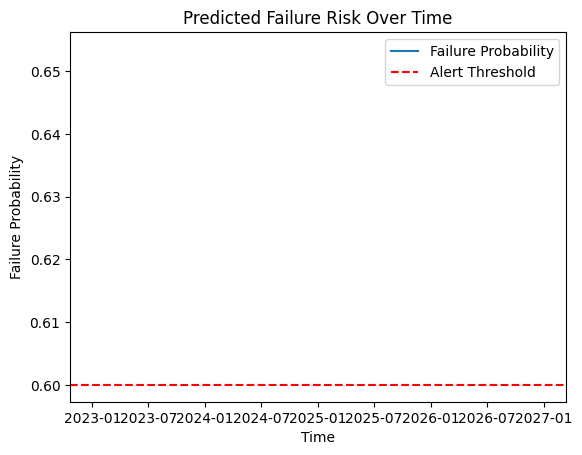

In [13]:
# Visualizzazione rischio nel tempo
plt.figure()
plt.plot(
    battery_df_test["timestamp"],
    battery_df_test["failure_probability"],
    label="Failure Probability"
)

plt.axhline(THRESHOLD, color="red", linestyle="--", label="Alert Threshold")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Failure Probability")
plt.title("Predicted Failure Risk Over Time")
plt.show()


In [14]:
# Salvare il modello LSTM
import joblib

model.save("../models/lstm_model.h5")
joblib.dump(scaler, "../models/scaler.pkl")


['../models/scaler.pkl']

## Operational Decision Support

- Predict failures before they occur
- Schedule preventive actions
- Avoid unnecessary interventions
- Reduce mission risk and cost
